<a href="https://colab.research.google.com/github/sasankapala/Sasanka--Analyst-Portfolio/blob/main/Customer_Attrition_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective:** A retail chain captures transaction data from all of it's distributors depicting product sales, customer demographics and distributor demographics. The objective of the project is to identify customer groups who are at risk of attrition and build a recommendation engine to suggest products for them. The transaction data is split into multiple files based on the distributor source and customer/distributor demographics are masked to maintain confidentiality


**Methodology:** \\
**Step 1:** \\


*  We join the data from multiple files and then clean it up to handle for any missing values or incorrect data types.
*  We then perform simple Exploratory Data Analysis to understand how different data points are distributed



In [ ]:
# import modules
import pandas as pd # for data analysis
import glob
import os
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# clustering
from sklearn.cluster import MiniBatchKMeans


# Define the path to your Excel files
path = '/content/drive/MyDrive/Analytics Projects/Customer Attrition Project/Data/'


# Get a list of all Excel files in the directory
all_files = glob.glob(os.path.join(path, "*.xlsx"))

# Create an empty list to store the DataFrames
all_dfs = []

# Iterate through each Excel file
for file in all_files:
    # Read the Excel file into a DataFrame with header
    df = pd.read_excel(file, header=0, usecols=range(15))
    all_dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
merged_df = pd.concat(all_dfs, ignore_index=True, axis = 0)

merged_df.head

# Print the merged DataFrame
# To see the output, run the code.
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961610 entries, 0 to 961609
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Transaction Date              961610 non-null  object 
 1   Year                          961610 non-null  int64  
 2   Month                         961610 non-null  int64  
 3   Report Date                   961610 non-null  object 
 4   Distributor Name              961610 non-null  object 
 5   SAP Material IDH              961609 non-null  float64
 6   SAP Material IDH Description  961609 non-null  object 
 7   Unit of Measure               961608 non-null  object 
 8   Quantity                      961610 non-null  int64  
 9   Distributor Unit Cost         961610 non-null  float64
 10  Extended Value                961610 non-null  float64
 11  End Customer Name             961599 non-null  object 
 12  SAP End Customer State        961586 non-nul

In [ ]:
# Checking if any of the columns have null values
merged_df.isnull().sum()

#Imputing Customer State Null values with 'Others'
merged_df['SAP End Customer State'].fillna('Others', inplace=True)

#dropping any remaining null value rows
merged_df = merged_df.dropna(how='any')

# Converting data types of each column based on their values
cleaned_data = merged_df.copy()
cleaned_data['Transaction Date'] = pd.to_datetime(cleaned_data['Transaction Date'], dayfirst=True)
cleaned_data['Report Date'] = pd.to_datetime(cleaned_data['Report Date'], dayfirst=True)
cleaned_data['SAP Material IDH'] = pd.to_numeric(cleaned_data['SAP Material IDH'])

cleaned_data.info()

#Writing cleaned data to csv for future use
cleaned_data.to_csv(path+"cleaned.csv", index = False)

<ipython-input-3-e6c33733b701>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['SAP End Customer State'].fillna('Others', inplace=True)


<class 'pandas.core.frame.DataFrame'>
Index: 961596 entries, 0 to 961609
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Transaction Date              961596 non-null  datetime64[ns]
 1   Year                          961596 non-null  int64         
 2   Month                         961596 non-null  int64         
 3   Report Date                   961596 non-null  datetime64[ns]
 4   Distributor Name              961596 non-null  object        
 5   SAP Material IDH              961596 non-null  float64       
 6   SAP Material IDH Description  961596 non-null  object        
 7   Unit of Measure               961596 non-null  object        
 8   Quantity                      961596 non-null  int64         
 9   Distributor Unit Cost         961596 non-null  float64       
 10  Extended Value                961596 non-null  float64       
 11  End Customer Name 

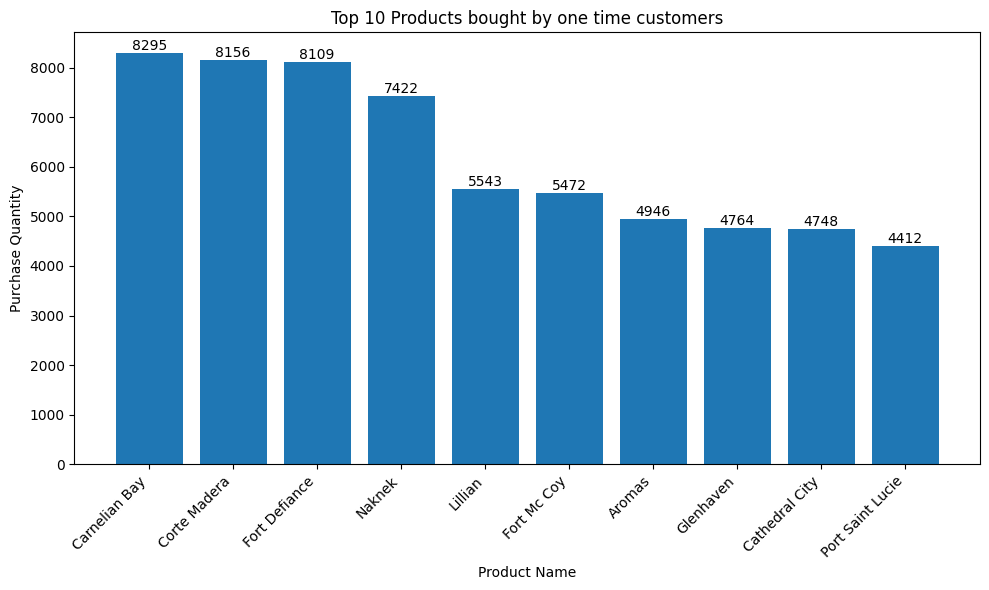

In [ ]:
# Exploratory Data Analysis
Distribution_Count = cleaned_data.groupby(['End Customer Name'])['Distributor Name'].nunique().reset_index()
mutiple_distribution_customers = Distribution_Count[Distribution_Count['Distributor Name']>1]

# histogram of number of customers with different number of distributors

counts, bins, patches = plt.hist(mutiple_distribution_customers['Distributor Name'], bins= np.arange(2,11) , rwidth=0.8)

bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.xticks(bin_centers, labels=bins[:-1].astype(int))

# Add count labels
for count, bin_edge in zip(counts, bins):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, int(count),
             ha='center', va='bottom')

plt.xlabel('# Distributors')
plt.ylabel('Customer Count')
plt.title('# Customer x Distributors')
plt.show()

# one time customers under each distributor
transaction_count = cleaned_data.groupby(['End Customer Name'])['Transaction Date'].nunique().reset_index()

onetime_trans_customers = transaction_count[transaction_count['Transaction Date'] == 1]

onetime_trans_cust_count = cleaned_data[cleaned_data['End Customer Name'].isin(onetime_trans_customers['End Customer Name'])].groupby(['Distributor Name'])['End Customer Name'].nunique().reset_index()
total_cust_count = cleaned_data.groupby(['Distributor Name'])['End Customer Name'].nunique().reset_index()

onetime_trans_cust_count = onetime_trans_cust_count.merge(total_cust_count,on=['Distributor Name'])

onetime_trans_cust_count['% of One Time Customers'] = onetime_trans_cust_count['End Customer Name_x']/onetime_trans_cust_count['End Customer Name_y']

onetime_trans_cust_count_sorted = onetime_trans_cust_count.sort_values(by=['% of One Time Customers'], ascending=False)

# bar graph of % of one time customers under each distributor
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
bars = plt.bar(onetime_trans_cust_count_sorted['Distributor Name'], onetime_trans_cust_count_sorted['% of One Time Customers'])
plt.xlabel('Distributor Name')
plt.ylabel('% of One Time Customers')
plt.title('Percentage of One-Time Customers per Distributor')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01,
             f'{round(yval * 100, 1)}%', ha='center', va='bottom')

plt.show()


onetime_trans_product_count = cleaned_data[cleaned_data['End Customer Name'].isin(onetime_trans_customers['End Customer Name'])].groupby(['SAP Material IDH','SAP Material IDH Description'])['Quantity'].sum().reset_index()
onetime_trans_product_count_sorted = onetime_trans_product_count.sort_values(by=['Quantity'], ascending=False).head(10)

# bar graph of % of one time customers under each distributor

plt.figure(figsize=(10, 6))  # Adjust figure size if needed
bars_2 = plt.bar(onetime_trans_product_count_sorted['SAP Material IDH Description'], onetime_trans_product_count_sorted['Quantity'])
plt.xlabel('Product Name')
plt.ylabel('Purchase Quantity')
plt.title('Top 10 Products bought by one time customers')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

for bar in bars_2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01,
             yval, ha='center', va='bottom')

plt.show()

In [ ]:
"""# Feature Engineering"""

"""
cleaned data is ready to be rolled up to transactional level to create file
used for dashboard exploratory analysis, rfm analysis, and to help generate features
used in recommendation engine
"""
#roll up clean data to transactional and distributor level for each customer

Transactional_Data = cleaned_data.groupby(['End Customer Name','Transaction Date','Distributor Name'])[['Quantity','Extended Value']].sum().reset_index()

#Downloading the cleaned data in a csv format for future use. You can change the path here.
Transactional_Data.to_csv(path+"Clean_Data_grouped_at_transaction_date.csv")

#Roll up transactional data at a customer level to create features for customer recommendation engine
Transaction_data = cleaned_data.groupby(['End Customer Name','Transaction Date'])[['Extended Value','Quantity']].sum().reset_index()


In [ ]:
#Calculate median spend and quantity per customer
med_spend =  Transaction_data.groupby(['End Customer Name'])['Extended Value'].median().reset_index()
med_spend = med_spend.rename(columns = {'Extended Value':'Median_Transact_Spend'})

med_quant =  Transaction_data.groupby(['End Customer Name'])['Quantity'].median().reset_index()
med_quant = med_quant.rename(columns = {'Quantity':'Median_Transact_Quant'})

#Calculate total quantity and total spend purchased for each customer over dataset timeframe (3 years)
sum_quant = Transaction_data.groupby(['End Customer Name'])['Quantity'].sum().reset_index()
#sum_quant = sum_quant.rename(columns = {'Quantity':'Total Quantity'})

sum_spend = Transaction_data.groupby(['End Customer Name'])['Extended Value'].sum().reset_index()
#sum_spend = sum_spend.rename(columns = {'Extended Value':'Total Extended Value'})

#Get number of transactions by customer
count_transact_count = Transaction_data.groupby(['End Customer Name'])['Transaction Date'].count().reset_index()
count_transact = count_transact_count.rename(columns = {'Transaction Date':'# of Transactions'})


In [ ]:
#Get customers with total quanity purchased and money spent in one dataframe
Customer_with_totals = pd.merge(sum_quant,sum_spend,on=['End Customer Name'])
#Add counts to dataframe to generate averages
Add_Counts = pd.merge(Customer_with_totals,count_transact,on=['End Customer Name'])
With_Avg_Spend = Add_Counts.assign(Avg_Spend_per_Trans=Add_Counts['Extended Value']/Add_Counts['# of Transactions'])
With_Avgs = With_Avg_Spend.assign(Avg_Quant_per_Trans=With_Avg_Spend['Quantity']/With_Avg_Spend['# of Transactions'])

#Add in median values to dataframe
With_Medians = With_Avgs.merge(med_spend,on=['End Customer Name']).merge(med_quant,on=['End Customer Name'])


#Get only purchases to calculate last 3 purchase average and median values
only_purch = merged_df[merged_df['Quantity']>0]

#Get last 3 purchases quantity and spend for each customer
purch_quant = only_purch.groupby(['End Customer Name','Transaction Date'])['Quantity'].sum().reset_index()
purch_spend = only_purch.groupby(['End Customer Name','Transaction Date'])['Extended Value'].sum().reset_index()

recent_purch_quant = purch_quant.sort_values('Transaction Date',ascending=False).groupby(['End Customer Name']).head(3)
recent_purch_spend= purch_spend.sort_values('Transaction Date',ascending=False).groupby(['End Customer Name']).head(3)

In [ ]:
#Take average and median for those last 3 purchases
avg_recent_purch_quant = recent_purch_quant.groupby(['End Customer Name'])['Quantity'].mean().reset_index()
avg_recent_purch_quant = avg_recent_purch_quant.rename(columns = {'Quantity':'Last_3_Purch_Avg_Quant'})
median_recent_purch_quant = recent_purch_quant.groupby(['End Customer Name'])['Quantity'].median().reset_index()
median_recent_purch_quant = median_recent_purch_quant.rename(columns = {'Quantity':'Last_3_Purch_Median_Quant'})

avg_recent_purch_spend = recent_purch_spend.groupby(['End Customer Name'])['Extended Value'].mean().reset_index()
avg_recent_purch_spend = avg_recent_purch_spend.rename(columns = {'Extended Value':'Last_3_Purch_Avg'})

median_recent_purch_spend = recent_purch_spend.groupby(['End Customer Name'])['Extended Value'].median().reset_index()
median_recent_purch_spend = median_recent_purch_spend.rename(columns = {'Extended Value':'Last_3_Purch_Median'})

#Dataframe with customer and aggregates for latest purchases and overall spend and quantity purchased to be fed into recommendation engine
Customers_With_Features = With_Medians.merge(avg_recent_purch_quant,on=['End Customer Name']).merge(median_recent_purch_quant,on=['End Customer Name']).merge(avg_recent_purch_spend,on=['End Customer Name']).merge(median_recent_purch_spend,on=['End Customer Name'])

#Downloading the cleaned data in a csv format for future use. You can change the path here.
Customers_With_Features.to_csv(path+"Customers_With_Features.csv")


In [ ]:
"""# RFM Analysis

Here, we first calculate the number of transactions made by each customer(Frequency), the recency of their latest purchase(Recency) and their total purchase value with henkel(Monetary Value) which will be then divied into quartiles and ranked 1-4 based on their quantile. A final combination of RFM ranking is then created which will be used to define different segments of the customer base
"""

#Ignoring all warning ⚠ messages thrown
import warnings
warnings.filterwarnings('ignore')

# import libraries
# Please import any other required libraries here in case some of the libraries change
import pandas as pd #Data manipulation and analysis

# Setting the correct date format just to be sure and considering only purchase transaction
cleaned_data['Transaction Date'] = pd.to_datetime(cleaned_data['Transaction Date'])
cleaned_data = cleaned_data[cleaned_data['Extended Value'] >0] # Removing returns whose extended value will be <=0

#Extracting unique customers so that all values calculated will be at this level.
tx_data = cleaned_data
tx_user = pd.DataFrame(tx_data['End Customer Name'].unique())
tx_user.columns = ['End Customer Name']

#get the max purchase date for each customer and create a dataframe with it
tx_max_purchase = tx_data.groupby('End Customer Name')["Transaction Date"].max().reset_index()
tx_max_purchase.columns = ['End Customer Name','MaxPurchaseDate']

#We calculate recency using the maximum transaction date available in the data.
#Each customer's transaction date is compared to the maximum date till which the data is available to calculate the recency

tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our unique user dataframe

tx_user = pd.merge(tx_user, tx_max_purchase[['End Customer Name','Recency']], on='End Customer Name')

#get frquency of transactions for each user and create a dataframe with it

tx_frequency = tx_data.groupby('End Customer Name')["Transaction Date"].count().reset_index()
tx_frequency.columns = ['End Customer Name','Frequency']

#add this frequency values to our unique user dataframe

tx_user = pd.merge(tx_user, tx_frequency, on='End Customer Name')
tx_user.head()

#calculate Monetary Value for each customer and add it to our unique user dataframe which already contains frequency and recency

tx_data['Revenue'] = tx_data["Extended Value"]
tx_revenue = tx_data.groupby('End Customer Name').Revenue.sum().reset_index()

tx_user = pd.merge(tx_user, tx_revenue, on='End Customer Name')
tx_user.head()

###Calculating different quantile values for Recency, Frequncy and Revenue which we might be using in creating segments
quantiles = tx_user[['Recency', 'Frequency', 'Revenue']].quantile([.2, .25, .3, .35, .4, .5, .6, .75, .8, .9]).to_dict()

###creating a function to get quantile values of recency and then ranking them 1-4 from lowest to highest
# 4 means more recent customer and 1 means less recent customer
def r_score(r):
    if r <= quantiles['Recency'][.25]:
        return 4
    elif r > quantiles['Recency'][.25] and r <= quantiles['Recency'][.50]:
        return 3
    elif r > quantiles['Recency'][.50] and r <= quantiles['Recency'][.75]:
        return 2
    elif r > quantiles['Recency'][.75]:
        return 1
    else:
        return 1
###creating a function to get quantile values of frequency and then ranking them 1-4 from lowest to highest
# 4 means high frequency  customer and 1 means less frequent customer
def f_score(f):
    if f > quantiles['Frequency'][.75]:
        return 4
    elif f > quantiles['Frequency'][.50] and f <= quantiles['Frequency'][.75] :
        return 3
    elif f > quantiles['Frequency'][.25] and f <= quantiles['Frequency'][.50] :
        return 2
    else:
        return 1

###creating a function to get quantile values of Revenue and then ranking them 1-4 from lowest to highest
# 4 means high Monetary value  customer and 1 means less Monetary value customer
def m_score(m):
    if m > quantiles['Revenue'][.75]:
        return 4
    elif m > quantiles['Revenue'][.50] and m <= quantiles['Revenue'][.75] :
        return 3
    elif m > quantiles['Revenue'][.25] and m <= quantiles['Revenue'][.50] :
        return 2
    else:
        return 1

#Applying the functions to the existing data so that we obtain R,F,M scores for each customer based on their respective values
rfm2 = tx_user.copy()
rfm2['r_score'] = rfm2.Recency.apply(lambda x: r_score(x))
rfm2['f_score'] = rfm2.Frequency.apply(lambda x: f_score(x))
rfm2['m_score'] = rfm2.Revenue.apply(lambda x: m_score(x))
rfm2['rfm'] = rfm2['r_score'].map(str)+rfm2['f_score'].map(str) + rfm2['m_score'].map(str)

rfm2.head(10)

# You can change the path here
rfm2.to_csv(path+'RFM_Customer_Scores.csv')

#Defining function for assigning segment names
def segment(r,f,m):
    if r==4 and f==4 and m==4:
        return 'Best Customer'
    elif (r==4 and f==4 and m==3) or (r==3 and f==4 and m==4):
        return 'Loyal Customer'
    elif (r==4 and f==4 and m<=2) or (r==4 and f==3 and m>=1) :
        return 'Potential Loyalist'
    elif r==4 and f<=2 and m>=3:
        return 'Promising'
    elif r==4 and f<=2 and m<=2:
        return 'New Customer'
    elif (r==3 and f==1 and m==4) or (r==3 and f==4 and m<=3) or (r==3 and f==3 and m>=2) or (r==3 and f==2 and m>=3) :
        return 'Need Attention'
    elif (r==2 and f>=3 and m>=3) or (r==2 and f<=2 and m==4):
        return 'At Risk'
    elif (r==3 and f==2 and m<=2) or (r==3 and f==1 and m<=3) or (r==2 and f>=3 and m<=2) or (r==3 and f>=3 and m<=1) or (r==2 and f>=2 and m<=1):
        return 'Potential Loss'
    elif (r==2 and f==2 and m==2) or (r==2 and f==2 and m==3) or (r==2 and f==1 and m<=3) or (r==1 and m>=3 and f==2) or (r==1 and m>=3 and f==3) or (r==1 and f==2 and m==3):
        return 'Hibernating'
    elif (r==1 and f>=1 and m==4):
        return 'Cannot Lose Them'
    elif (r==1 and f>=1 and m==1) or (r==1 and f==1 and m==2) or (r==1 and f==1 and m==3) or (r==1 and f==2 and m==2):
        return 'True Attrition'
    else:
        return 'Others'

#Applying the defined function to the data
rfm2['segment'] = rfm2.apply(lambda x: segment(x.r_score,x.f_score,x.m_score),axis=1)

rfm2.to_csv(path+"Customers_With_Segments.csv", index = False)


In [ ]:
"""# Recommendation Engine"""

def r_engine(cust_list, no_of_r, path1, path2):

  # Reading the csv file for customer transactions
  df1 = pd.read_csv(path1, low_memory=False)

  # Keeping numerical identifiers for Customer (for clustering purpose)
  df1['End Customer Name'] = df1['End Customer Name'].replace('Customer ', '',regex=True)

  # Reading the csv file with the pre-processed data
  cleaned = pd.read_csv(path2, low_memory=False)

  # Function to segregate the states to regions
  def f(row):
    if row  == 'CT' or row  == 'ME' or row  == 'MA' or row  == 'NH' or row  == 'NJ' or row  == 'NY' or row  == 'PA' or row  == 'RI' or row  == 'VT':
      val = 'Northeast'
    elif row  == 'AL' or row  == 'AR' or row  == 'DE' or row  == 'FL' or row  == 'GA' or row  == 'KY' or row  == 'LA' or row  == 'MD' or row  == 'MS' or row  == 'NC' or row  == 'SC' or row  == 'TN' or row  == 'VA' or row  == 'WV':
      val = 'Southeast'
    elif row  == 'IL' or row  == 'IN' or row  == 'IA' or row  == 'KS' or row  == 'MI' or row  == 'MN' or row  == 'MO' or row  == 'OH' or row  == 'ND' or row  == 'NE' or row  == 'SD' or row  == 'WI':
      val = 'Midwest'
    elif row  == 'AZ' or row  == 'NM' or row  == 'OK' or row  == 'TX' or row  == 'MI' or row  == 'MN' or row  == 'MO' or row  == 'OH' or row  == 'ND' or row  == 'NE' or row  == 'SD' or row  == 'WI':
      val = 'Southwest'
    elif row  == 'AK' or row  == 'CA' or row  == 'CO' or row  == 'HI' or row  == 'ID' or row  == 'NV' or row  == 'MT' or row  == 'OR' or row  == 'UT' or row  == 'WA' or row  == 'DC' or row  == 'WY':
      val = 'West'
    else:
      val = 'Others'
    return val

  # Applying the function to "SAP End Customer State" column
  cleaned['Region'] = cleaned['SAP End Customer State'].apply(f)

  # Adding regions
  temp = cleaned[['End Customer Name','Region']]
  temp = temp.groupby(['End Customer Name'])['Region'].max().reset_index()
  df_reg = pd.get_dummies(temp['Region'])

  # Merging it with the final data
  df_final = df1.merge(df_reg, how='left', left_index=True, right_index=True)

  ### Clustering
  ## Optimal number of clusters
  Sum_of_squared_distances = []
  K = range(1,20)
  for k in K:
    km = MiniBatchKMeans(n_clusters=k)
    km = km.fit(df_final)
    Sum_of_squared_distances.append(km.inertia_)

  # function to get the optimal number of clusters
  import math
  def optimal_number_of_clusters(Sum_of_squared_distances):
    x1, y1 = 1, Sum_of_squared_distances[0]
    x2, y2 = 20, Sum_of_squared_distances[len(Sum_of_squared_distances)-1]

    distances = []
    for i in range(len(Sum_of_squared_distances)):
        x0 = i+2
        y0 = Sum_of_squared_distances[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)

    return distances.index(max(distances)) + 2

  # Calling the function to get the optimal number of clusters
  optimal_clusters = optimal_number_of_clusters(Sum_of_squared_distances)

  # Applying Mini Batch K-Means Clustering
  model = MiniBatchKMeans(n_clusters=optimal_clusters)
  model.fit_predict(df_final.iloc[:, 1:].values)
  df_final['clusterID'] = model.labels_

  # Extracting customers and products aggreagated with sum of quantities
  pro = cleaned[['End Customer Name','SAP Material IDH Description','Quantity']].copy()
  pro = pro.groupby(['End Customer Name','SAP Material IDH Description'])['Quantity'].sum().reset_index()
  pro['End Customer Name'] = pro['End Customer Name'].replace('Customer ', '',regex=True)
  pro['End Customer Name'] = pro['End Customer Name'].astype(int)

  # Extracting customers and their respective cluster IDs
  clusters = df_final[['End Customer Name','clusterID']].copy()
  clusters['End Customer Name'] = clusters['End Customer Name'].astype(int)

  # Merging the above 2 files to further use them in determining the products bought by each cluster of customers
  pro1 = pro.merge(clusters, on='End Customer Name', how='left')
  pro1 = pro1.groupby(['clusterID','SAP Material IDH Description'])['Quantity'].sum().reset_index()
  pro1_filtered = pro1[pro1['Quantity'] > 0]

  # Function to extract the top 5 recommendations for each customer
  def recomm(customer_list):

    # Target cluster is the cluster ID for our target customer
    target_cluster = (int(clusters[clusters['End Customer Name'] == int(customer_list.replace('Customer ', ''))].clusterID))

    # Extracting the unique list of products bought by the target cluster, sorted in descending order of quantity
    pro2 = (pro1_filtered[pro1_filtered['clusterID'] == target_cluster]).sort_values('Quantity', ascending=False).round(2)
    pro3 = pro2['SAP Material IDH Description'].unique()

    # Extracting the unique list of products bought by the target customer
    pro_c = pro[pro['End Customer Name'] == int(customer_list.replace('Customer ', ''))]
    pro_c_1 = pro_c['SAP Material IDH Description'].unique()

    # Deleting the products that are already bought by our target customer
    pro4 = list(set(pro3) - set(pro_c_1))

    # Recommending the top products (Here no. of recommendations can be adjusted while calling the function)
    if len(pro4) == 0:
      recommendations = pro3[0:no_of_recommendations]
    else:
      recommendations = pro4[0:no_of_recommendations]
    return recommendations
  # Calling the above recomm function using map, so that the function runs for each customer in the cust_list
  list_of_recommendations = list(map(recomm,cust_list))
  return list_of_recommendations


In [ ]:
cust_df = pd.read_csv(path+"Customers_With_Segments.csv", low_memory=False)
test_list = cust_df[cust_df['segment']=='At Risk']['End Customer Name'].tolist()

no_of_recommendations = 5

path1 = path+"Customers_With_Features.csv"
path2 = path+"cleaned.csv"

# Calling the recommendation engine function
df_recomm = pd.DataFrame(r_engine(test_list,no_of_recommendations,path1,path2))

# r_engine(cust_list, no_of_r, path1, path2)
# It has 4 attributes/variables that can be adjusted. Please refer the above cell for the format of each variable.

# "cust_list" is the list of customers foe whom the recommendations are required. Ideally in this case, we are passing the customers with high risk
# Note: This should be a list with each element being 'End Customer Name'. Example: ['Customer 1', 'Customer 1234'], in this format.

# "no_of_r" is the number of recommendations for each customer. This should be an integer.

# "path1" is the path for the the csv file "Customers_With_Features.csv"

# "path2" is the path for the the csv file "cleaned.csv"

# Transposing the data so that each column is a customer and each row in the column is a product recommendation for that customer
df_r = df_recomm.T
df_r.columns = test_list
df_r

# Storing the recommendations into a csv file
df_r.to_csv(path+"Recommendations_at_risk_customers.csv", index = False)
